In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve , accuracy_score
import torch.optim as optim
import torch.utils.data as data
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

In [65]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
df_sample_dataset = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')

In [66]:
df_train.head(10)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
5,5,6,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7,1
6,6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,28.4,0
7,7,8,1019.7,15.8,13.6,12.7,11.8,96.0,100.0,0.0,50.0,52.8,1
8,8,9,1017.4,17.6,16.5,15.6,12.5,86.0,100.0,0.0,50.0,37.5,1
9,9,10,1025.4,16.5,14.4,12.0,8.6,77.0,84.0,1.0,50.0,38.3,0


In [67]:
df_test.head(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [68]:
df_sample_dataset.head(5)

,id,rainfall
0,2190,0
1,2191,0
2,2192,0
3,2193,0
4,2194,0


In [69]:
#handle missing values
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
1


In [70]:
missing_test = df_test.isnull().sum()

In [71]:
print("\nmissing values in test dataset df_test:")
print(missing_test[missing_test > 0])


missing values in test dataset df_test:
winddirection    1
dtype: int64


In [72]:
df_test['winddirection'] = df_test['winddirection'].fillna(df_test['winddirection'].mean())

In [74]:
print(df_test.isnull().sum().sum())

0


In [98]:
df = df_train.drop(columns=['id'])

In [99]:
df_train.head(2)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1


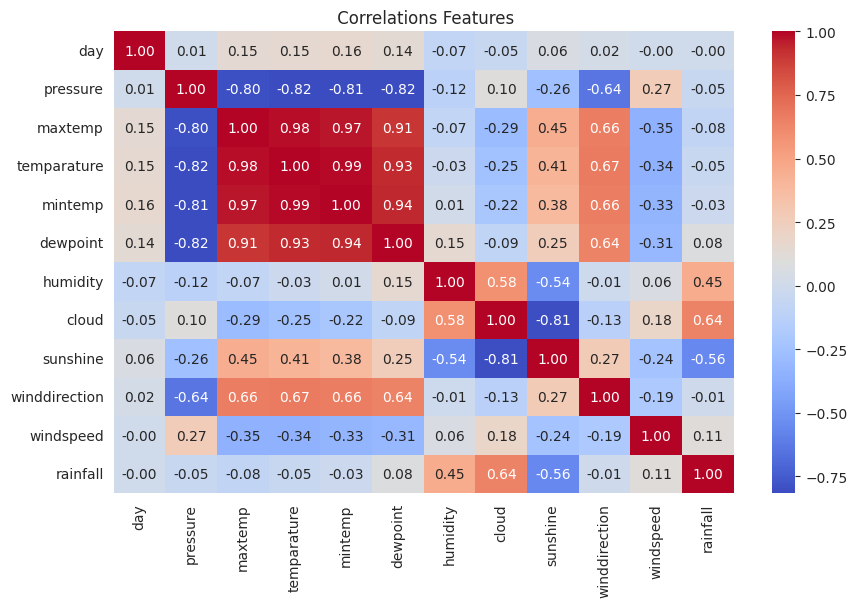

In [91]:
def correlate():
    maty = df.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(maty,annot=True,cmap='coolwarm',fmt=".2f")
    plt.title(" Correlations Features")
    plt.show()

correlate()

In [165]:
#fixing outliers

def outlier_plot(col1,col2='day'):
    plt.figure(figsize=(8,4))
    sns.set_style('ticks')
    sns.scatterplot(x=df[col2],y=df[col1],color='red')
    plt.title(f'{col1} before outlier is fixed')
    plt.xlabel('day')
    plt.ylabel(col1)
    plt.show()
    

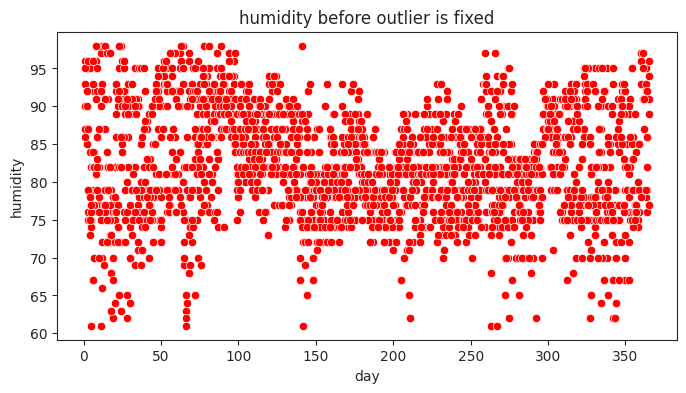

In [166]:
outlier_plot('humidity')

In [100]:
def handle_outlier(col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    median_value = df[col].median()
    df[col] = np.where((df[col]< lower_bound) | (df[col]> upper_bound),median_value,df[col])
    return df

In [101]:
for col in df.columns:
    if col !='day' and col !='rainfall':
        df = handle_outlier(col)
        

In [102]:
#plotting after fixing outliers

In [163]:
def fixed_outlier_plot(col1, col2='day'):
    plt.figure(figsize=(8,4))
    sns.set_style('ticks')
    sns.scatterplot(x=df[col2],y=df[col1])
    plt.title(f'{col1} after fixing outliers')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

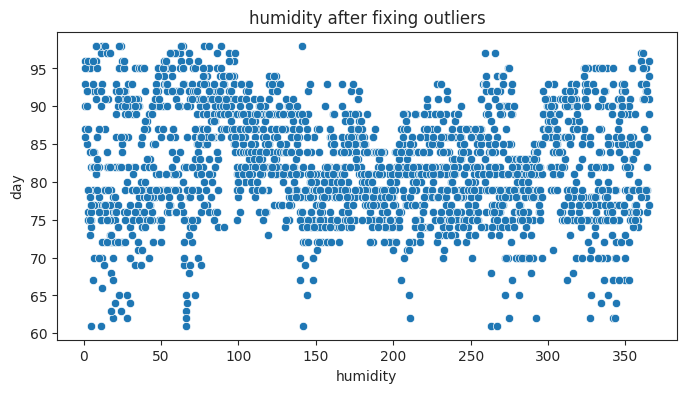

In [164]:
fixed_outlier_plot('humidity')

In [106]:
# feature engineering
def feature_eng(df):
    df['day_sin'] = np.sin(2 * np.pi * df['day']/365)
    df['day_cos']  = np.cos(2 * np.pi * df['day']/365)

#feels like temp
    df['heat_index'] = (df['temparature'] * df['humidity'])/100
    #wind chill factor
    df['wind_chill'] = df['temparature'] - (df['windspeed']* 0.7)
    return df

df = feature_eng(df)

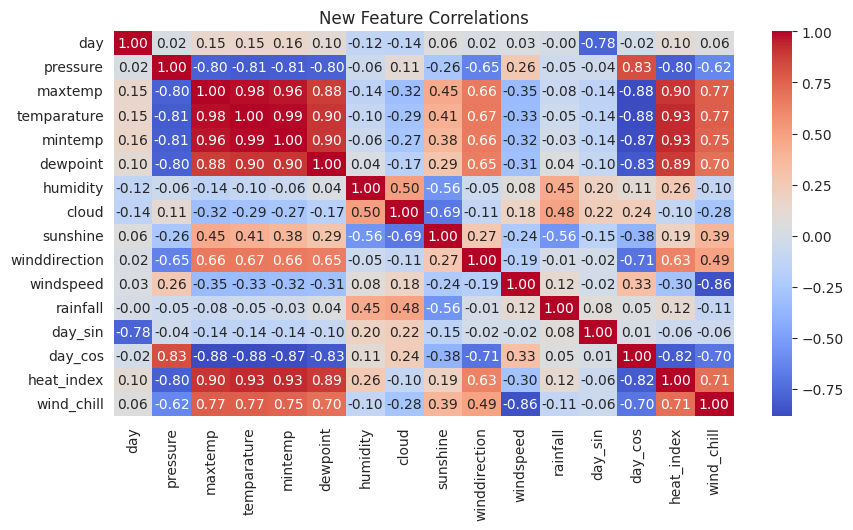

In [107]:
def new_correlate(df):
    mat = df.corr()
    plt.figure(figsize=(10,5))
    sns.heatmap(mat,annot=True,cmap='coolwarm',fmt='.2f')
    plt.title('New Feature Correlations')
    plt.show()

new_correlate(df)

In [108]:
df.head(5)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,day_sin,day_cos,heat_index,wind_chill
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,0.017213,0.999852,17.922,8.56
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0.034422,0.999407,16.055,1.57
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,0.051620,0.998667,12.075,3.43
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,0.068802,0.997630,16.910,-7.12
4,5,1021.8,21.3,18.4,15.2,9.6,82.0,45.0,3.6,40.0,24.8,0,0.085965,0.996298,15.088,1.04


In [109]:
x = df.drop(columns =['rainfall'])
y = df['rainfall']

In [111]:
X_train ,X_test, Y_train , Y_test = train_test_split(x,y,test_size=0.25,random_state=42)
# scaling down the values bw 0 and 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#convert to tensors
X_train_tensor = torch.tensor(X_train,dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train,dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype= torch.float32)
Y_test_tensor = torch.tensor(np.array(Y_test),dtype=torch.float32).unsqueeze(1)

batch_size = 32

train_dataset = data.TensorDataset(X_train_tensor, Y_train_tensor)
train_dataloader = data.DataLoader(train_dataset,batch_size=batch_size, shuffle= True)


In [135]:
#create and train model
class BinaryClassification(nn.Module):
    def __init__(self, input_size=15):
        super().__init__()
        self.fc1 = nn.Linear(input_size,16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,1)
        #self.relu_layer = torchrelu()
        self.sigmoid_layer = nn.Sigmoid()
    def forward(self,x):
            x = torch.relu(self.bn1(self.fc1(x)))
            x = nn.Dropout(0.4)(x)
            x = torch.relu(self.fc3(x))
            x = self.fc4(x)
            x = self.sigmoid_layer(x)
            return x
            

In [136]:
model = BinaryClassification()


In [137]:
model.parameters

<bound method Module.parameters of BinaryClassification(
  (fc1): Linear(in_features=15, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)>

In [138]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(),lr=learning_rate, momentum=0.95)
criterion = nn.BCELoss()

In [139]:
num_epochs = 1000
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        if loss < best_loss:
            torch.save(model.state_dict(),'best_model_moment.pth')
        print(f'epoch:{epoch} loss:{loss.item():.3f}')
        

epoch:0 loss:0.451
epoch:100 loss:0.124
epoch:200 loss:0.351
epoch:300 loss:0.271
epoch:400 loss:0.410
epoch:500 loss:0.401
epoch:600 loss:0.186
epoch:700 loss:0.309
epoch:800 loss:0.545
epoch:900 loss:0.688


In [140]:
print(best_loss)

inf


In [142]:
#evaluate the model
best_model = BinaryClassification()
best_model.load_state_dict(torch.load('best_model_moment.pth'))

<ipython-input-142-185d3991597c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model_moment.pth'))


<All keys matched successfully>

In [143]:
best_model.eval()
with torch.no_grad():
    y_probs = best_model(X_test_tensor).numpy()
    y_pred = (y_probs > 0.5).astype(int)
    print("Accuracy: ",accuracy_score(Y_test,y_pred))

Accuracy:  0.843065693430657


In [144]:
test_dataset.head(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [146]:
def feature_eng(df):
    #cyclic encoding
    df['day_sin'] = np.sin(2 * np.pi * df['day']/365)
    df['day_cos'] = np.cos(2* np.pi * df['day']/365)

#feels like temperature
    df['heat_index'] = (df['temparature'] * df['humidity'])/100
# wind chiil composition
    df['wind_chill'] = df['temparature'] - (df['windspeed']*0.8)

    return df

test_df = feature_eng(test_dataset.drop(columns='id'))




In [147]:
test_df.head(5)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,day_sin,day_cos,heat_index,wind_chill
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3,0.017213,0.999852,15.168,-3.64
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3,0.034422,0.999407,16.005,-11.74
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9,0.051620,0.998667,8.944,-3.12
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6,0.068802,0.997630,12.975,-23.18
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4,0.085965,0.996298,9.384,-1.72


In [154]:
model.eval()
with torch.no_grad():
     test_probs = model(torch.tensor(scaler.fit_transform(test_df), dtype=torch.float32)).numpy()
     test_preds = (test_probs > 0.5).astype(int)

<ipython-input-154-87aa4fef13bd>:4: RuntimeWarning: invalid value encountered in greater
  test_preds = (test_probs > 0.5).astype(int)


In [158]:
final_output = pd.concat([pd.DataFrame(test_dataset['id']),pd.DataFrame(test_preds)],
                         axis=1,ignore_index=True)

In [159]:
final_output.head(5)


,0,1
0,2190,1
1,2191,1
2,2192,1
3,2193,0
4,2194,0


In [160]:
final_output.rename(columns={0:'id',1:'rainfall'},inplace=True)

In [161]:
final_output.head(5)

,id,rainfall
0,2190,1
1,2191,1
2,2192,1
3,2193,0
4,2194,0


In [162]:
final_output.to_csv('submission.csv',index=False)